<a href="https://colab.research.google.com/github/clysdid/from_scratch/blob/master/2_BERT_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pytorch BERT**

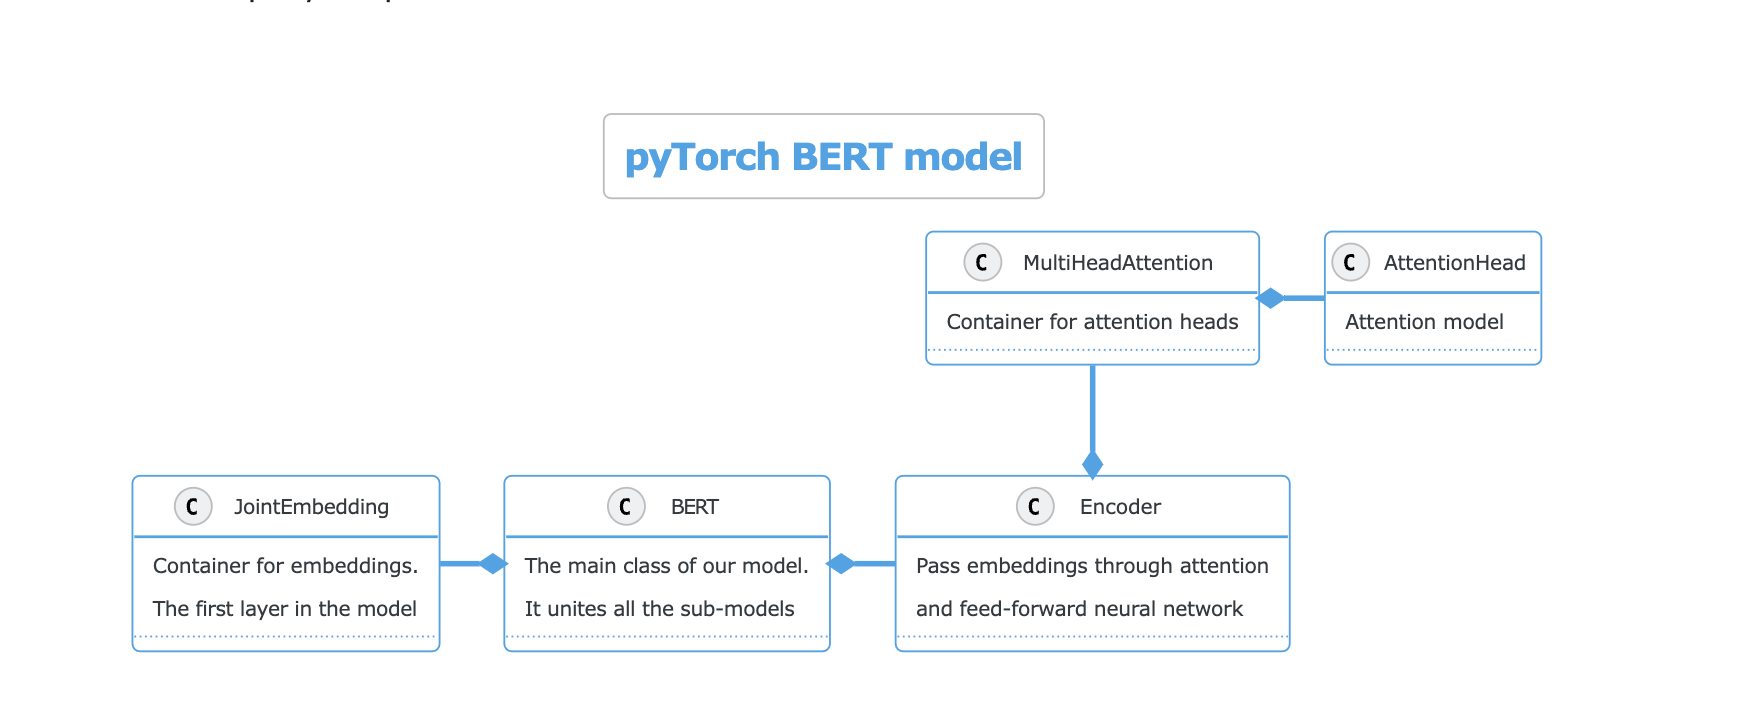

### 3가지 임베딩

In [1]:
train_data = 'bert from the very beginning'

word_set = set(train_data.split())

vocab = {tkn : i+2 for i, tkn in enumerate(word_set)}
vocab['<unk>'] = 0
vocab['<pad>'] = 1 # padding token 부분은 가중치가 업데이트 되지 않음.

import torch.nn as nn #신경망 모델 상속
embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=3, padding_idx=1)
print(embedding_layer.weight)


Parameter containing:
tensor([[-0.3541, -1.2216, -0.0734],
        [ 0.0000,  0.0000,  0.0000],
        [-0.2227,  1.4101,  0.1823],
        [-1.3079,  0.0043,  0.3297],
        [-1.0973, -0.7145, -1.1614],
        [-0.5388,  1.5113, -0.5665],
        [-0.9192, -0.1269,  1.7990]], requires_grad=True)


In [2]:
embedding_layer1 = nn.Embedding(num_embeddings=len(vocab), embedding_dim=2, padding_idx=1)
print(embedding_layer1.weight)

Parameter containing:
tensor([[-0.9095, -0.6470],
        [ 0.0000,  0.0000],
        [ 0.8001,  0.3543],
        [ 0.6908, -0.4769],
        [ 0.8480, -0.6338],
        [ 0.7095,  0.3977],
        [-0.9284, -0.5551]], requires_grad=True)


1. token embedding
- 입력된 토큰에 대한 임베딩

In [ ]:
import torch.nn as nn

class TokenEmbedding(nn.Embedding):
  def __init__(self, vocab_size, embed_size=512):
    super().__init__(vocab_size, embed_size, padding_idx =0)


2. Segment Embedding
- 두 문장 중 어디에 속하는지를 의미

In [ ]:
class SegmentEmbedding(nn.Embedding):
  def __init__(self, embed_size=512):
    super().__init__(3, embed_size, padding_idx=0) # segment id가 3가지 종류 (2면 패딩, 0,1이면 각각 문장을 의미)

3. position embedding
- 토큰 당 위치 정보

In [ ]:
import torch.nn as nn
import torch
import math


class PositionalEmbedding(nn.Module):
  def __init__(self, d_model, max_len=512):
    super().__init__()

    pe = torch.zeros(max_len, d_model).float()
    pe.require_grad = False

    position = torch.arange(0, max_len).float().unsqueeze(1)
    div_term = (torch.arange(0, d_model, 2).float()* -(math.log(10000.0)/d_model)).exp()

    pe[:, 0::2] = torch.sin(position*div_term)
    pe[:, 1::2] = torch.cos(position*div_term)

    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

  def forward(self, x):
    return self.pe[:, :x.size(1)]

Embedding all

In [ ]:
class BERTEmbedding(nn.Module):
  def __init__(self, vocab_size, embed_size, dropout=0.1):
    super().__init__()
    self.token = TokenEmbedding(vocab_size = vocab_size, embed_size = embed_size)
    self.position = PositionalEmbedding(d_model = self.token.embedding_dim)
    self.segment = SegmentEmbedding(embed_size = self.token.embedding_dim)
    self.dropout = nn.Dropout(p=dropout)
    self.embed_size = embed_size

  def forward(self, sequence, segment_label):
    x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
    return self.dropout(x)

### pre-training: MLM & NSP

1. MLM

In [ ]:
class MaskedLanguageModel(nn.Module):
  def __init__(self, hidden, vocab_size):
    super().__init__()
    self.linear = nn.Linear(hidden, vocab_size)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self, x):
    return self.softmax(self.linear(x))

2. NSP

In [20]:
class NextSentencePrediction(nn.Module) :
  def __init__(self, hidden):
    super().__init__()
    self.linear = nn.Linear(hidden, 2)
    self.softmax = nn.LogSoftmax(dim=-1)

  def forward(self,x):
    return self.softmax(self.linear(x[:,0]))

In [10]:
import torch
a = torch.tensor([[-0.9095, -0.6470],
        [ 0.0000,  0.0000],
        [ 0.8001,  0.3543],
        [ 0.6908, -0.4769],
        [ 0.8480, -0.6338],
        [ 0.7095,  0.3977],
        [-0.9284, -0.5551]])

In [12]:
a.shape

torch.Size([7, 2])

In [14]:
a.squeeze(-1)

tensor([[-0.9095, -0.6470],
        [ 0.0000,  0.0000],
        [ 0.8001,  0.3543],
        [ 0.6908, -0.4769],
        [ 0.8480, -0.6338],
        [ 0.7095,  0.3977],
        [-0.9284, -0.5551]])

In [18]:
b = a.unsqueeze(-1)
b

tensor([[[-0.9095],
         [-0.6470]],

        [[ 0.0000],
         [ 0.0000]],

        [[ 0.8001],
         [ 0.3543]],

        [[ 0.6908],
         [-0.4769]],

        [[ 0.8480],
         [-0.6338]],

        [[ 0.7095],
         [ 0.3977]],

        [[-0.9284],
         [-0.5551]]])

In [19]:
b.shape

torch.Size([7, 2, 1])

In [ ]:
class BERTLTM(nn.Module):
  def __init__(self, bert : BERT, vocab_size):
    super().__init__()
    self.bert = bert
    self.next_sentence = NextSentencePrediction(self.bert.hidden)
    self.mask_lm = MaskedLanguageModel(self.bert.hidden, vocab_size)

  def forward(self, x, segment_label):
    x = self.bert(x, segment_label)
    return self.next_sentence(x), self.mask_lm

### Training

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

In [ ]:
class BERTTrainer:
  # 앞에 일부 생략
  def __init__(self, bert: BERT, vocab_size: int,
                 train_dataloader: DataLoader, test_dataloader: DataLoader = None,
                 lr: float = 1e-4, betas=(0.9, 0.999), weight_decay: float = 0.01, warmup_steps=10000,
                 with_cuda: bool = True, cuda_devices=None, log_freq: int = 10):

    if with_cuda and torch.cuda.device_count()> 1:
      self.model = nn.DataParallel(self.model, device_ids = cuda_devices)


  def iteration(self, epoch, data_loader , train=True):
    avg_loss = 0.0
    total_correct = 0
    total_element = 0

    for i, data in data_iter:
      # 0. batch data를 디바이스로 할당
      data = {key:value.to(self.device) for key, value in data.items()}

      # 1. forward nsp and mlm
      next_sent_output, mask_lm_output = self.model.forward(data['bert_input'], data['segment_label'])

      # 2. nll(negative log likelihood) of nsp
      next_loss = self.criterion(next_sent_output, data['is_next'])

      # 2-2 nll loss of mlm
      mask_loss = self.criterion(mask_lm_output.transpose(1,2), data['bert_label']) # (batch_size, seq_length, embed_size)라면, transpose(1, 2)를 통해 (batch_size, embed_size, seq_length)로 바뀌게 됩니다.
      #  loss 합
      loss = next_loss + mask_loss

     # backward and optimization
      if train:
        self.optim_schedule.zero_grad()
        loss.backward()
        self.optim_schedule.step_and_update_lr()

      # nsp 정확도
      correct = next_sent_output.argmax(dim=-1).eq(data['is_next']).sum().item() # eq는 값이 같은지 비교
      avg_loss += loss.item()
      total_correct += correct
      total_element += data['is_next'].nelement() # 몇개의 요소로 구성되어있는지

- https://coaxsoft.com/blog/building-bert-with-pytorch-from-scratch
- https://needmorecaffeine.tistory.com/31
- https://github.com/codertimo/BERT-pytorch/tree/master